# Laminography automatic alignment
This notebook demonstrates new tools to automatically align the tilt and center of rotation offset parameters for data collected in a laminography geometry, to optimise the best reconstructed volume.

Laminography is an imaging techique, similar to tomography, where projections are collected at multiple positions around a sample then used to reconstruct a 3D volume. Laminography is used on flat samples, where the typical tomography setup results in artefacts caused by un-even absorption between projections. In laminography, the rotation axis is tilted relative to the detector plane to make the absorption more equal.

The notebook laminography_artefacts.ipynb shows examples of the kind of artefacts that are solved by and caused by the laminography setup. It also shows what happens if the tilt or centre of rotation offset is not precisely known.

In [1]:
from scripts.geometry_corrector import GeometryCorrector
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionData, AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Normaliser
from cil.utilities.display import show1D, show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.plugins.astra.processors import FBP
import numpy as np
from scipy.spatial.transform import Rotation as R

c:\Users\bgb37495\AppData\Local\miniconda3\envs\lamino\Lib\site-packages\dxchange\__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


First we load a DIAD dataset

In [2]:
file_path = "alignment_methods/data/k11-54286.nxs"
    
data = HDF5_utilities.read(file_path, '/entry/imaging/data')
image_key = HDF5_utilities.read(file_path, '/entry/instrument/EtherCAT/image_key')
angles = HDF5_utilities.read(file_path, '/entry/imaging_sum/smaract_zrot')

unique_keys, counts = np.unique(image_key, return_counts=True)
for key, count in zip(unique_keys, counts):
    key_type = {0: "Tomography", 1: "Flat field", 2: "Dark field"}.get(key, f"Unknown ({key})")
    print(f"  {key_type} images: {count}")

flat_fields = data[np.where(image_key == 1)[0]]
dark_fields = data[np.where(image_key == 2)[0]]
projections = data[np.where(image_key == 0)[0]]
projection_angles = angles[np.where(image_key == 0)[0]]

  Tomography images: 1441
  Flat field images: 20
  Dark field images: 20


Next we describe the experimental geometry. We setup the detector (perhaps we can get this from the file in future) and make an initial guess of the tilted rotation axis and centre of rotation offset.

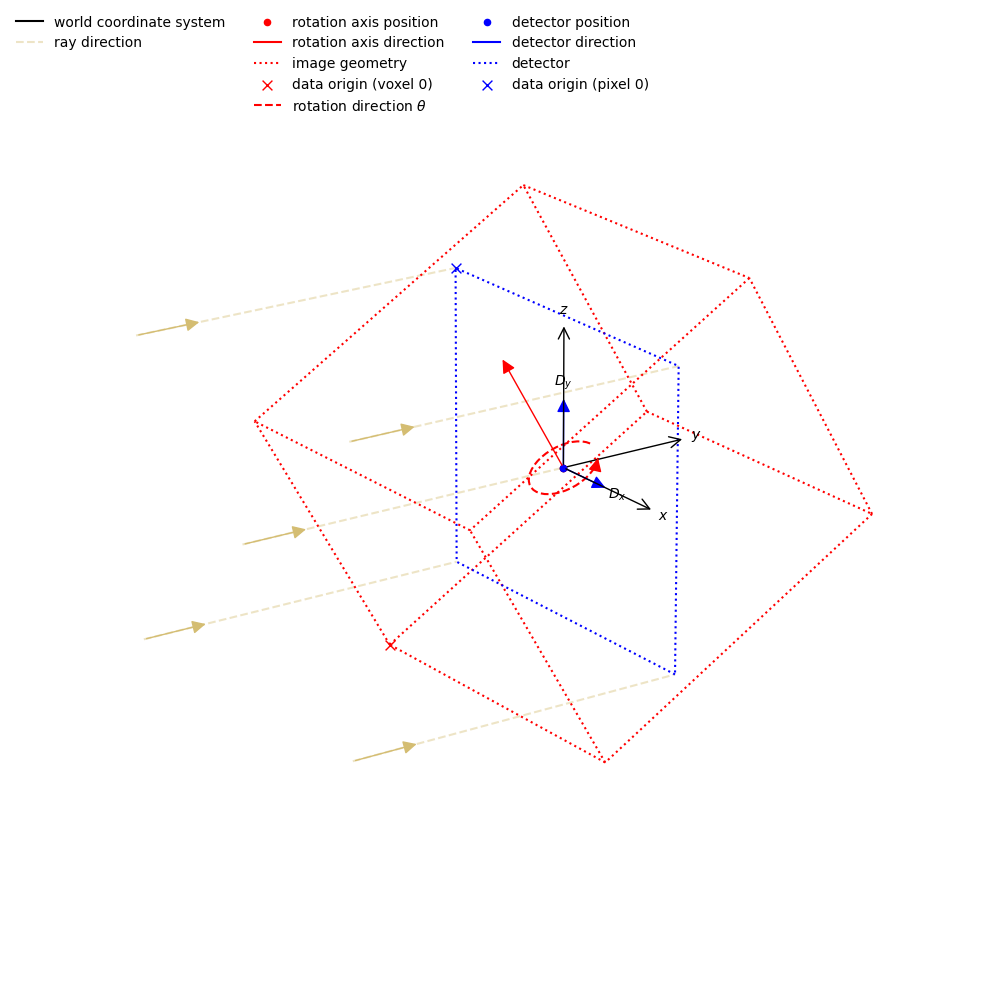

In [3]:
detector_pixel_size=0.54 # um
ag = AcquisitionGeometry.create_Parallel3D(units="microns")

ag.set_panel(num_pixels=[projections.shape[2], projections.shape[1]],
        origin='top-left',
        pixel_size=detector_pixel_size)

ag.set_angles(projection_angles)

cor = 0 # pix, initial guess
tilt = 30 # deg, initial guess

ag.set_centre_of_rotation(offset=cor, distance_units='pixels')

tilt_direction_vector=np.array([1, 0, 0])
original_rotation_axis=np.array([0, 0, 1])

rotation_matrix = R.from_rotvec(np.deg2rad(tilt) * tilt_direction_vector)
tilted_rotation_axis = rotation_matrix.apply(original_rotation_axis)

ag.config.system.rotation_axis.direction = tilted_rotation_axis

show_geometry(ag)

acq_data = AcquisitionData(projections, deep_copy=False, geometry=ag)

Next we apply a flat and dark field correction and apply the Beer-Lambert law

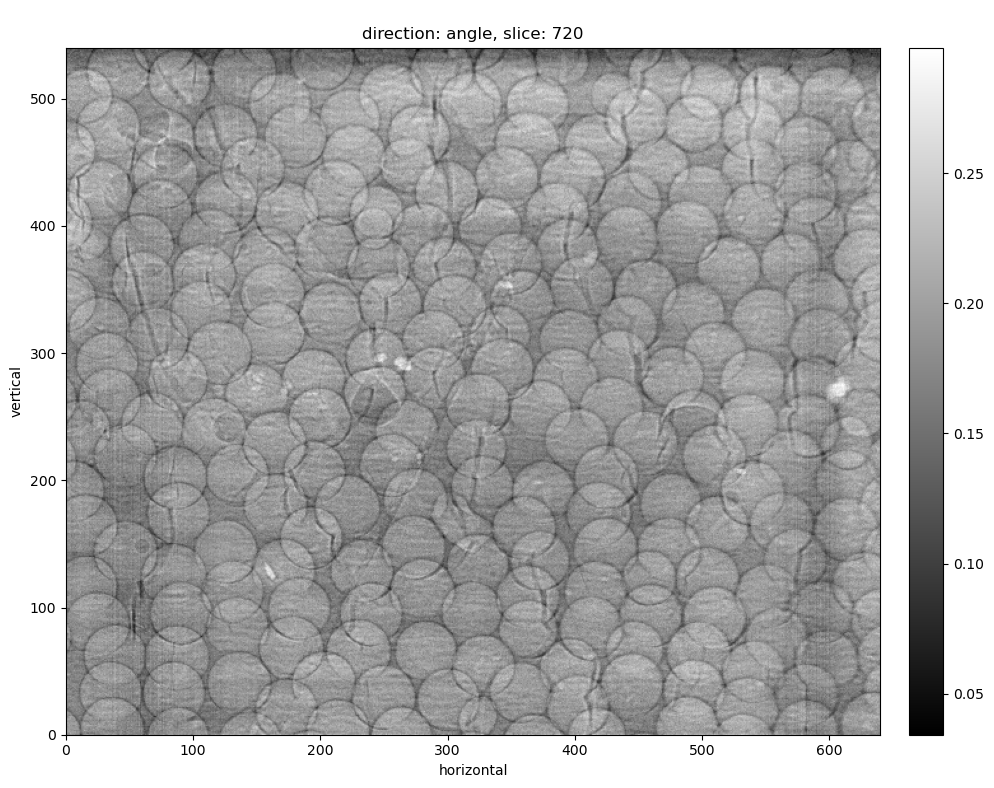

In [4]:
acq_data = Normaliser(np.mean(flat_fields, axis=0), np.mean(dark_fields, axis=0))(acq_data)
acq_data = TransmissionAbsorptionConverter(min_intensity=1e-3)(acq_data)
show2D(acq_data)

We reorder the data in the order required by astra

In [5]:
acq_data.reorder('astra')
print(acq_data.dimension_labels)

(<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)


Now we try reconstructing the data with this initial geometry guess

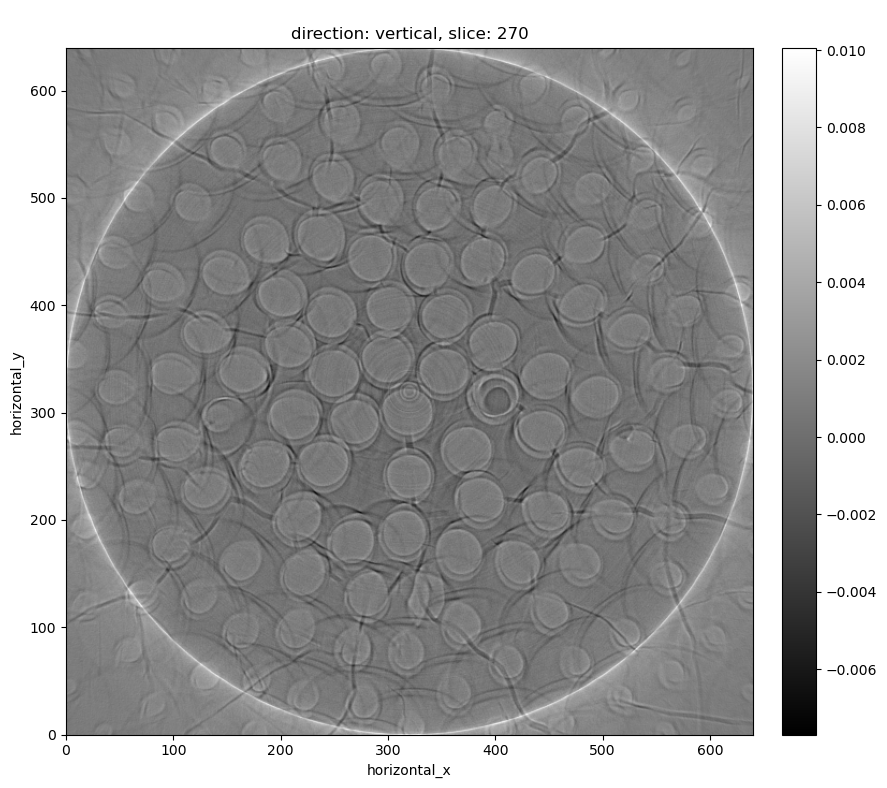

In [6]:
ag = acq_data.geometry
ig = ag.get_ImageGeometry()

fbp = FBP(ig, ag)
recon = fbp(acq_data)
show2D(recon)


The reconstruction is almost recognisable as a flat sample containing many spheres, but there are strong artefacts. The double edges are characteristic of an error in the centre of rotation and the teardrop shape of the spheres at the edge suggest the tilt angle is incorrect.

Here we can use the GeometryCorrector tool to get a more accurate estimate of the tilt and centre of rotation parameters from the data itself. This tool uses a projection matching method to guess the geometry and minimise the difference between a reprojection reconstruction and the original projections. This method can be slow so we should minimise the reconstruction volume by choosing as few as possible voxels in the z direction. We can estimate a good number by checking the extent of the sample in the verical direction of our initial reconstruction. 

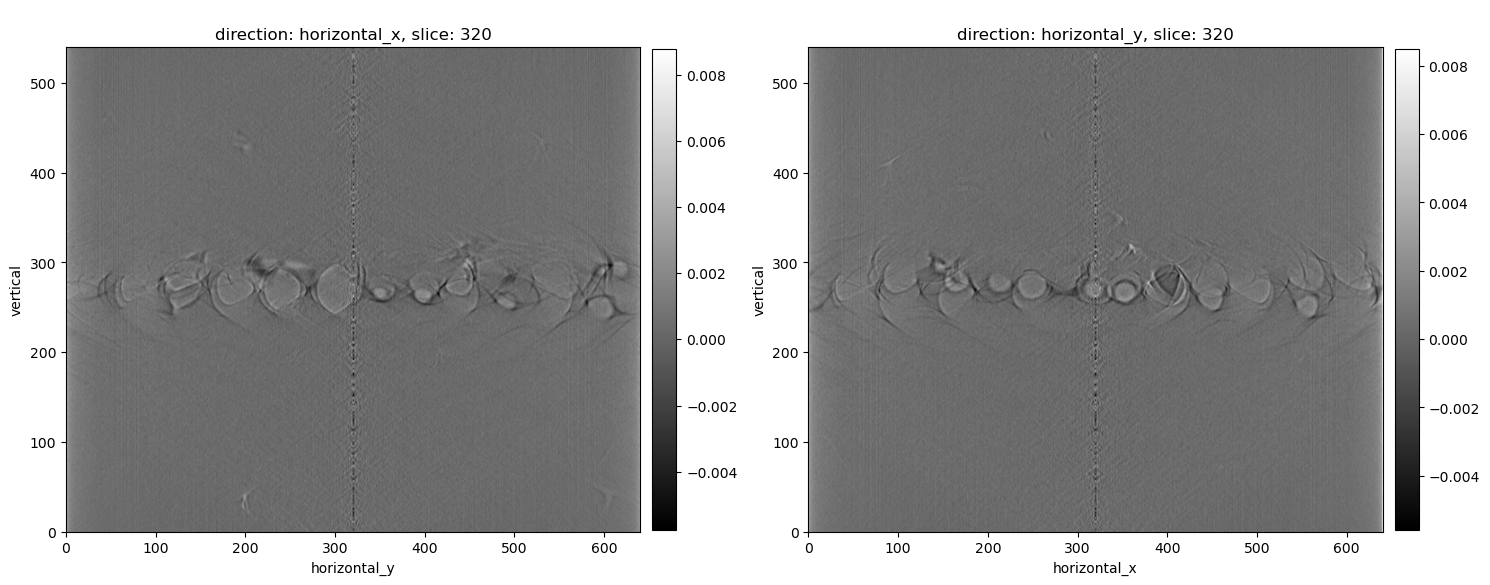

In [7]:
show2D(recon, slice_list=[('horizontal_x', recon.shape[2]//2), ('horizontal_y', recon.shape[1]//2)])

We see the sample is quite flat so we can choose around 250 z voxels around the centre, note if the initial geometry guess is very wrong the sample extent may differ considerable so don't make the z sampling too tight around the sample. 

For FBP reconstruction of tomography data, the Nyquist criterion requires the number of projections to be at least $\pi/2$ times the detector width. However, in laminography there is overlapping sampling of the reconstructed Fourier space, so the requirement can be relaxed. For the minimisation step we can therefore reduce the data size by binning the projections with the angle_binning parameter. If the minimised geometry is not good enough we can try increasing this to closer to the Nyquist criterion.

`GeometryCorrector` starts with a coarse minimisation using an initial_binning in detector space, then does a fine minimisation at full resolution. A larger initial binning might be a good idea if we want to search a wide range.

In [8]:
voxel_num_z = 250
angle_binning = 4
initial_binning = 4

Next we choose a parameter range to search. We define search bounds for both the tilt and centre of rotation, the wider the bounds the longer the coarse minimisation will take. Here we define quite wide bounds to demonstrate the method.

We also need to choose a parameter tolerance, e.g. how close to the correct parameter do we need to get. The more precise the tolerance the longer the fine minimisation will take. Typically, it's hard to see improvement in the reconstruction beyond around 1/100th of a degree or pixel.

In [9]:
tilt_bounds = (30, 40) # deg
cor_bounds = (-3, 3) # pixels

tilt_tol = 0.01 # deg
cor_tol = 0.01 # pixels

processor = GeometryCorrector(initial_parameters=(tilt, cor), parameter_bounds=(tilt_bounds, cor_bounds), parameter_tolerance=(tilt_tol, cor_tol),
                   voxel_num_z = voxel_num_z, initial_binning=initial_binning, angle_binning=angle_binning)
processor.set_input(acq_data)
data_corrected = processor.get_output()

tilt: 30.000000, cor: 0.000000, loss: 4.484169e+05
tilt: 33.819660, cor: 0.000000, loss: 4.283034e+05
tilt: 36.180340, cor: 0.000000, loss: 4.301339e+05
tilt: 32.360680, cor: 0.000000, loss: 4.377561e+05
tilt: 34.795867, cor: 0.000000, loss: 4.258229e+05
tilt: 34.838152, cor: 0.000000, loss: 4.258277e+05
tilt: 34.782533, cor: 0.000000, loss: 4.258236e+05
tilt: 34.809200, cor: 0.000000, loss: 4.258231e+05
tilt: 34.795867, cor: -0.708204, loss: 4.396582e+05
tilt: 34.795867, cor: 0.708204, loss: 4.117461e+05
tilt: 34.795867, cor: 1.583592, loss: 3.984527e+05
tilt: 34.795867, cor: 2.124612, loss: 3.944750e+05
tilt: 34.795867, cor: 2.518805, loss: 3.940797e+05
tilt: 34.795867, cor: 2.395549, loss: 3.939673e+05
tilt: 34.795867, cor: 2.342216, loss: 3.939843e+05
tilt: 34.795867, cor: 2.448883, loss: 3.939888e+05
tilt: 36.005971, cor: 3.000000, loss: 4.034529e+05
tilt: 33.819660, cor: 2.395549, loss: 4.016414e+05
tilt: 36.180340, cor: 2.395549, loss: 4.036847e+05
tilt: 32.360680, cor: 2.395549

Finally we do a full resolution reconstruction using the minimised parameters

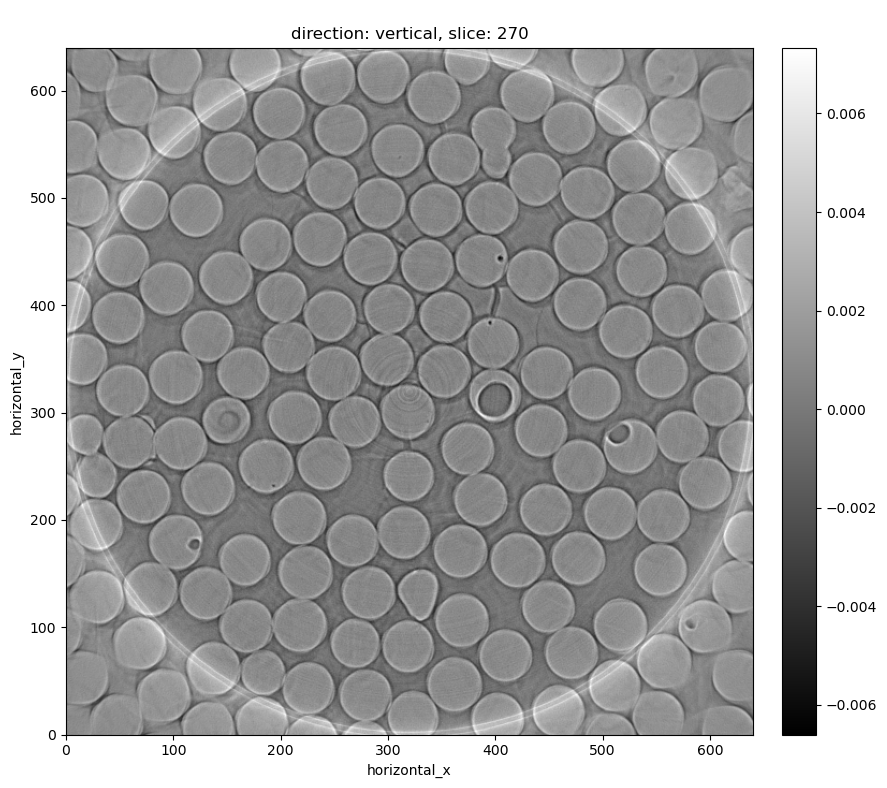

In [10]:
recon = FBP(acquisition_geometry=data_corrected.geometry)(data_corrected)
show2D(recon)